<a href="https://colab.research.google.com/github/ClintonBeyene/ETH-MedData-Warehouse/blob/main/03_Custom_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install roboflow ultralytics supervision roboflow

In [ ]:
!pip install inference

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import required libraries
from ultralytics import YOLO
import os
import pandas as pd
import glob
from IPython import display
from roboflow import Roboflow
from IPython.display import Image as IPyImage, display

In [ ]:
# Clear the output
display.clear_output()

In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.13 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.6/107.7 GB disk)


In [ ]:
from google.colab import userdata
ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("meddatawarehouse").project("meddata-warehouse")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

Ultralytics 8.3.13 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/MedData-Warehouse-1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

In [ ]:
!ls {HOME}/runs/detect/task4

ls: cannot access '/content/runs/detect/task4': No such file or directory


In [ ]:
!ls /content/drive/

MyDrive


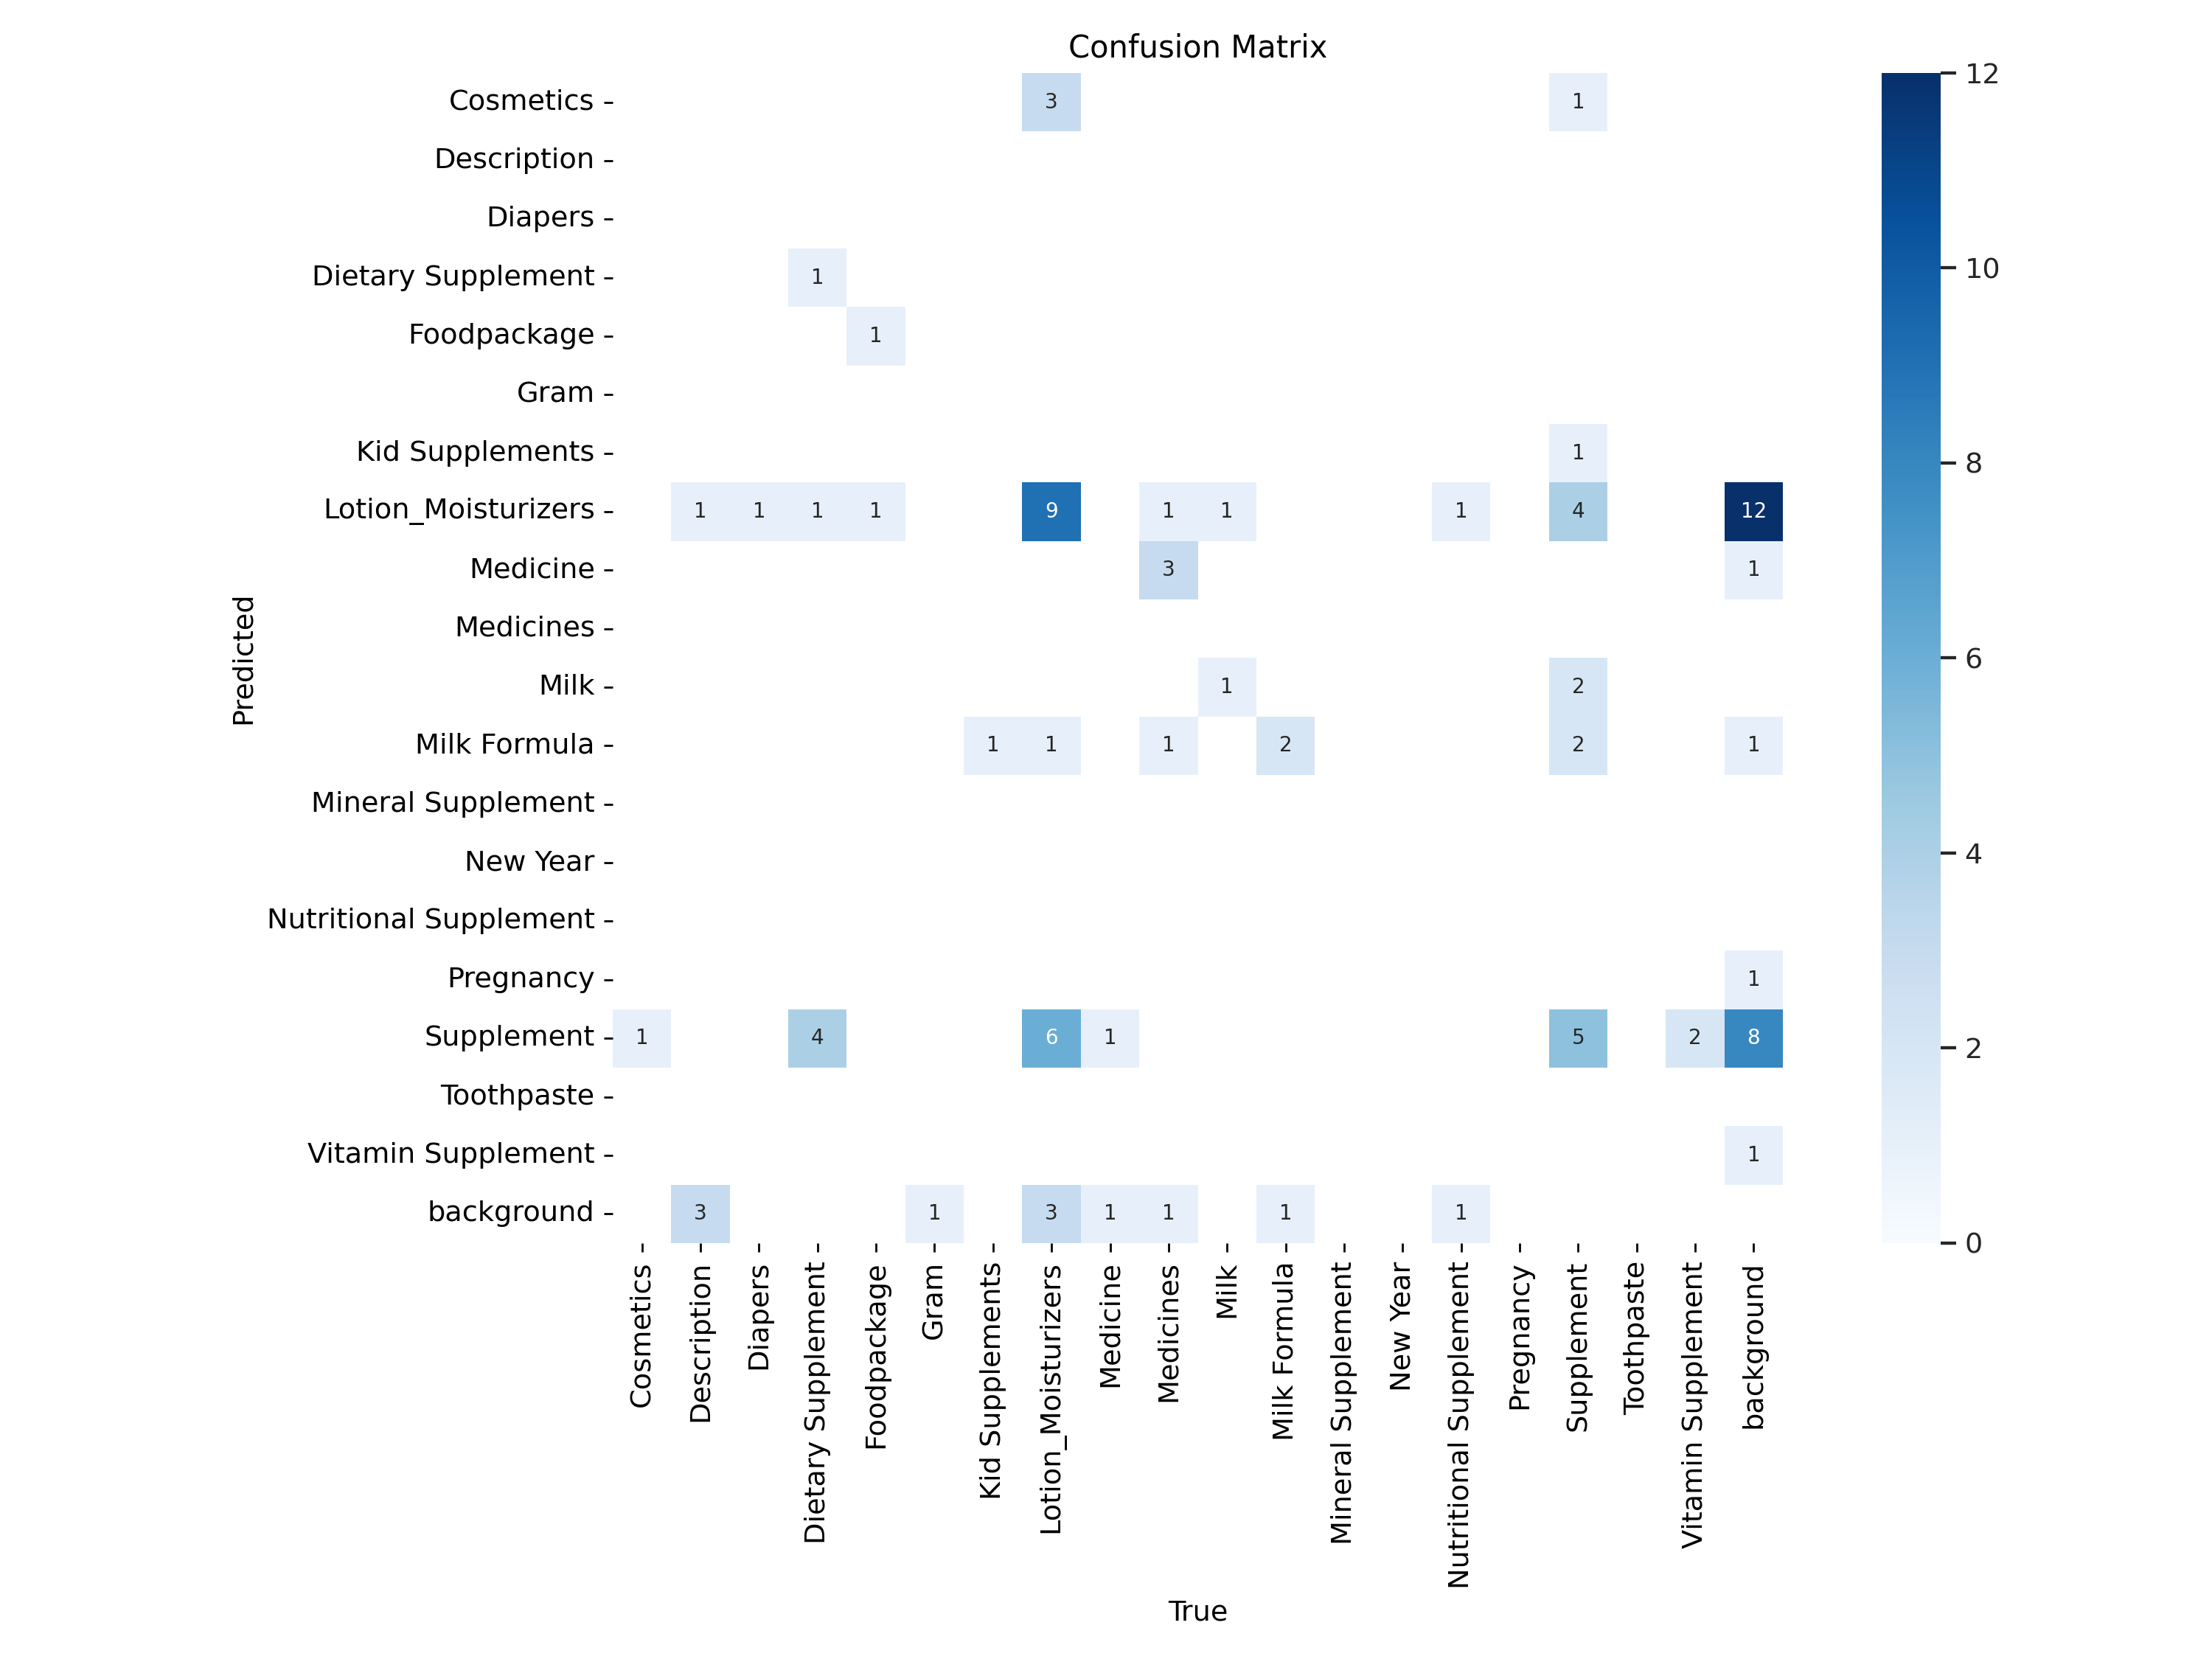

In [ ]:
IPyImage(filename=f'/content/runs/detect/train4/confusion_matrix.png', width=800)

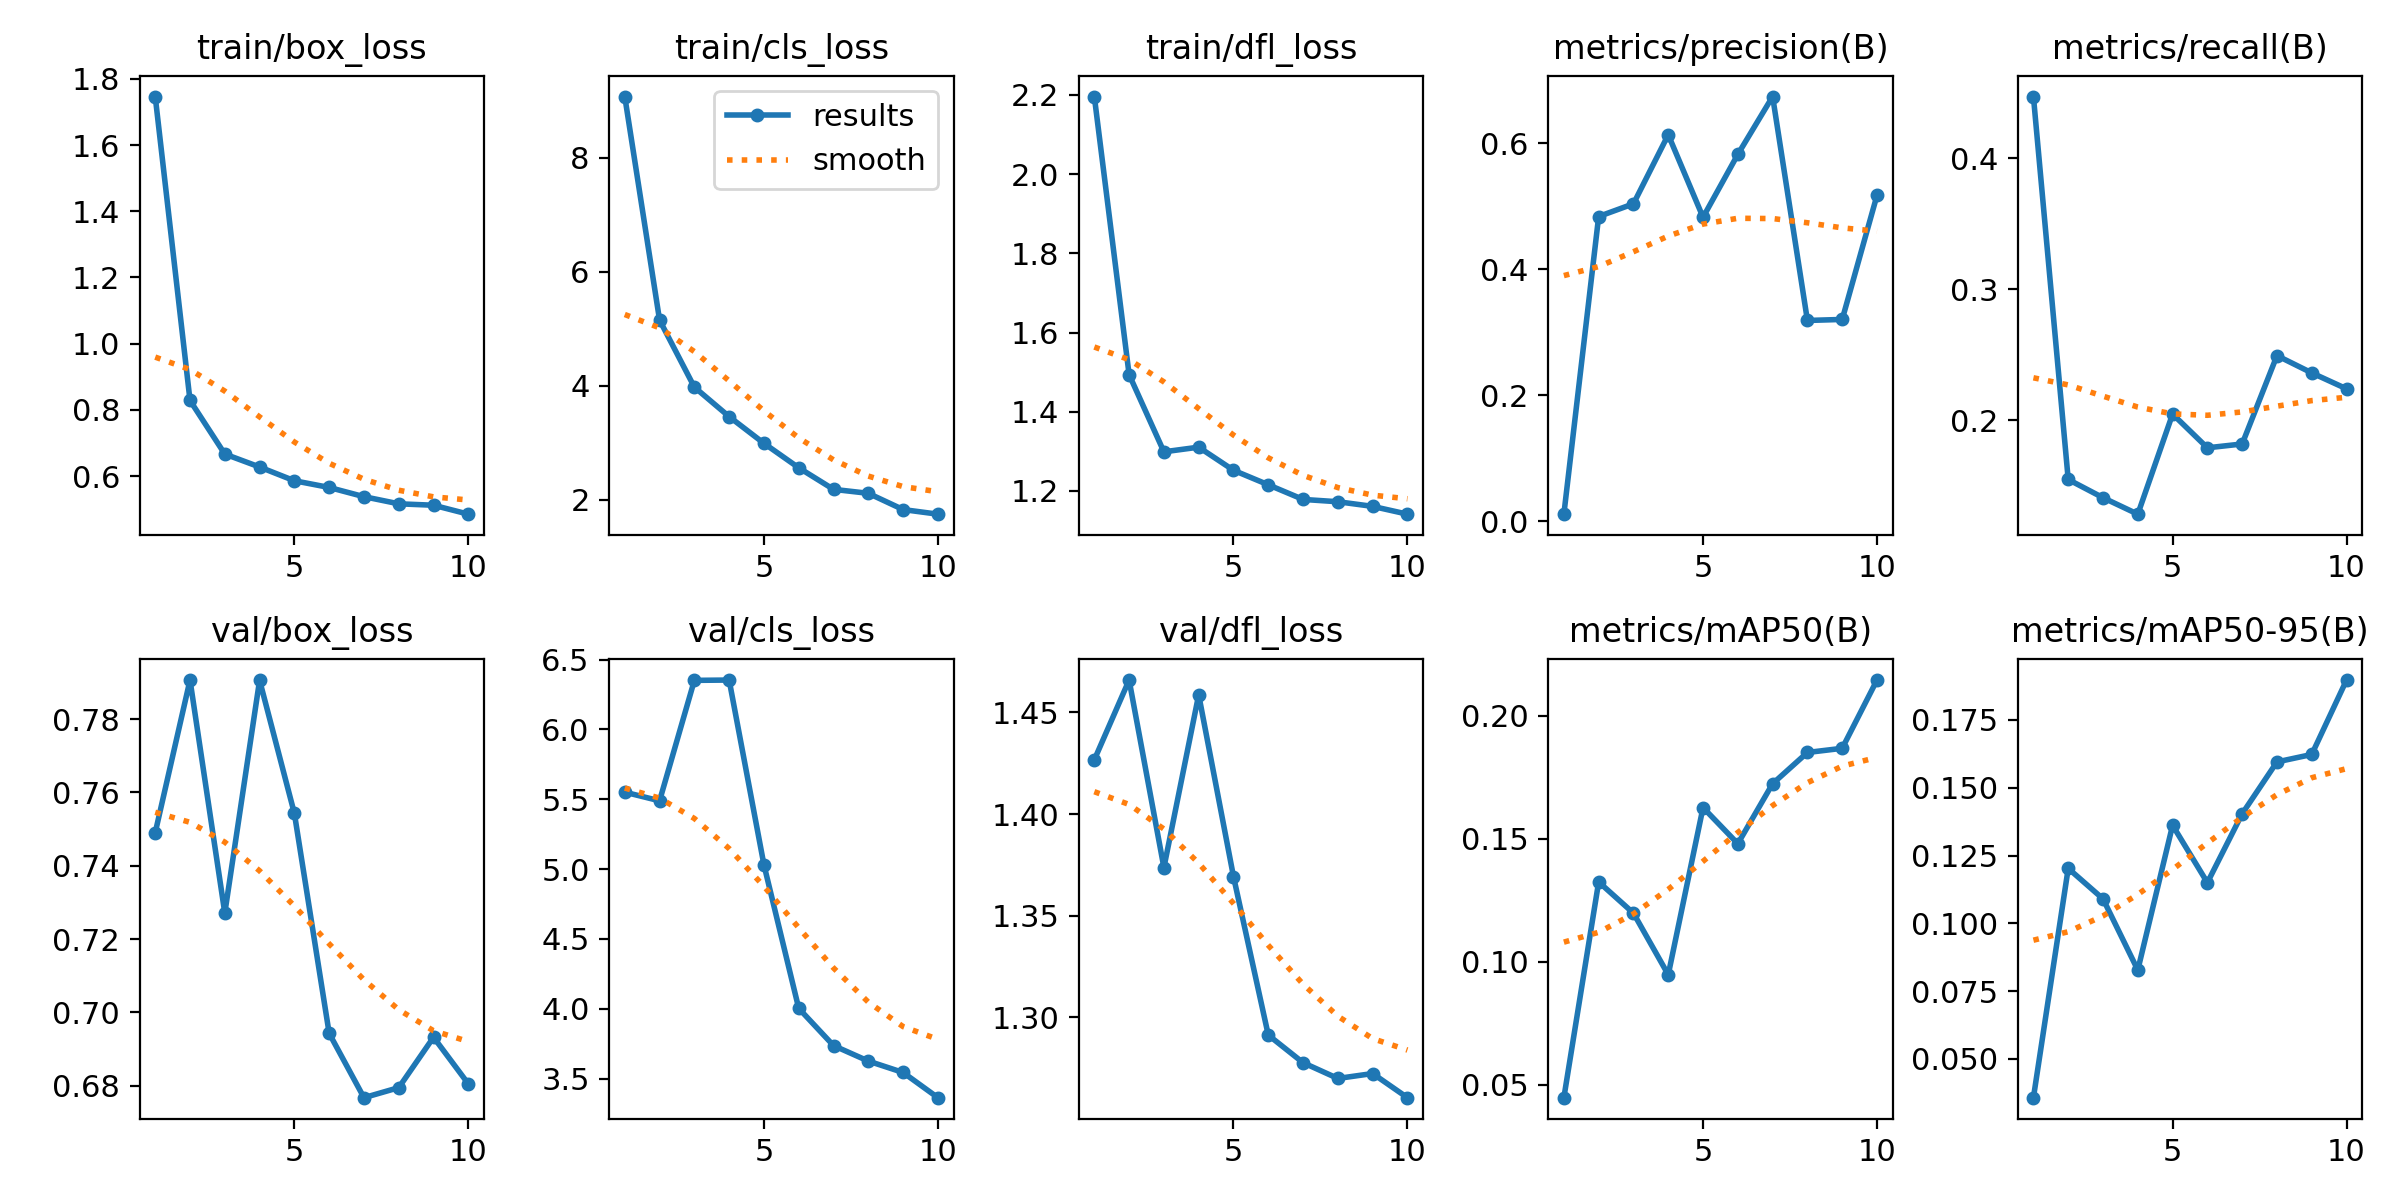

In [ ]:
IPyImage(filename=f'{HOME}/runs/detect/train4/results.png', width=800)

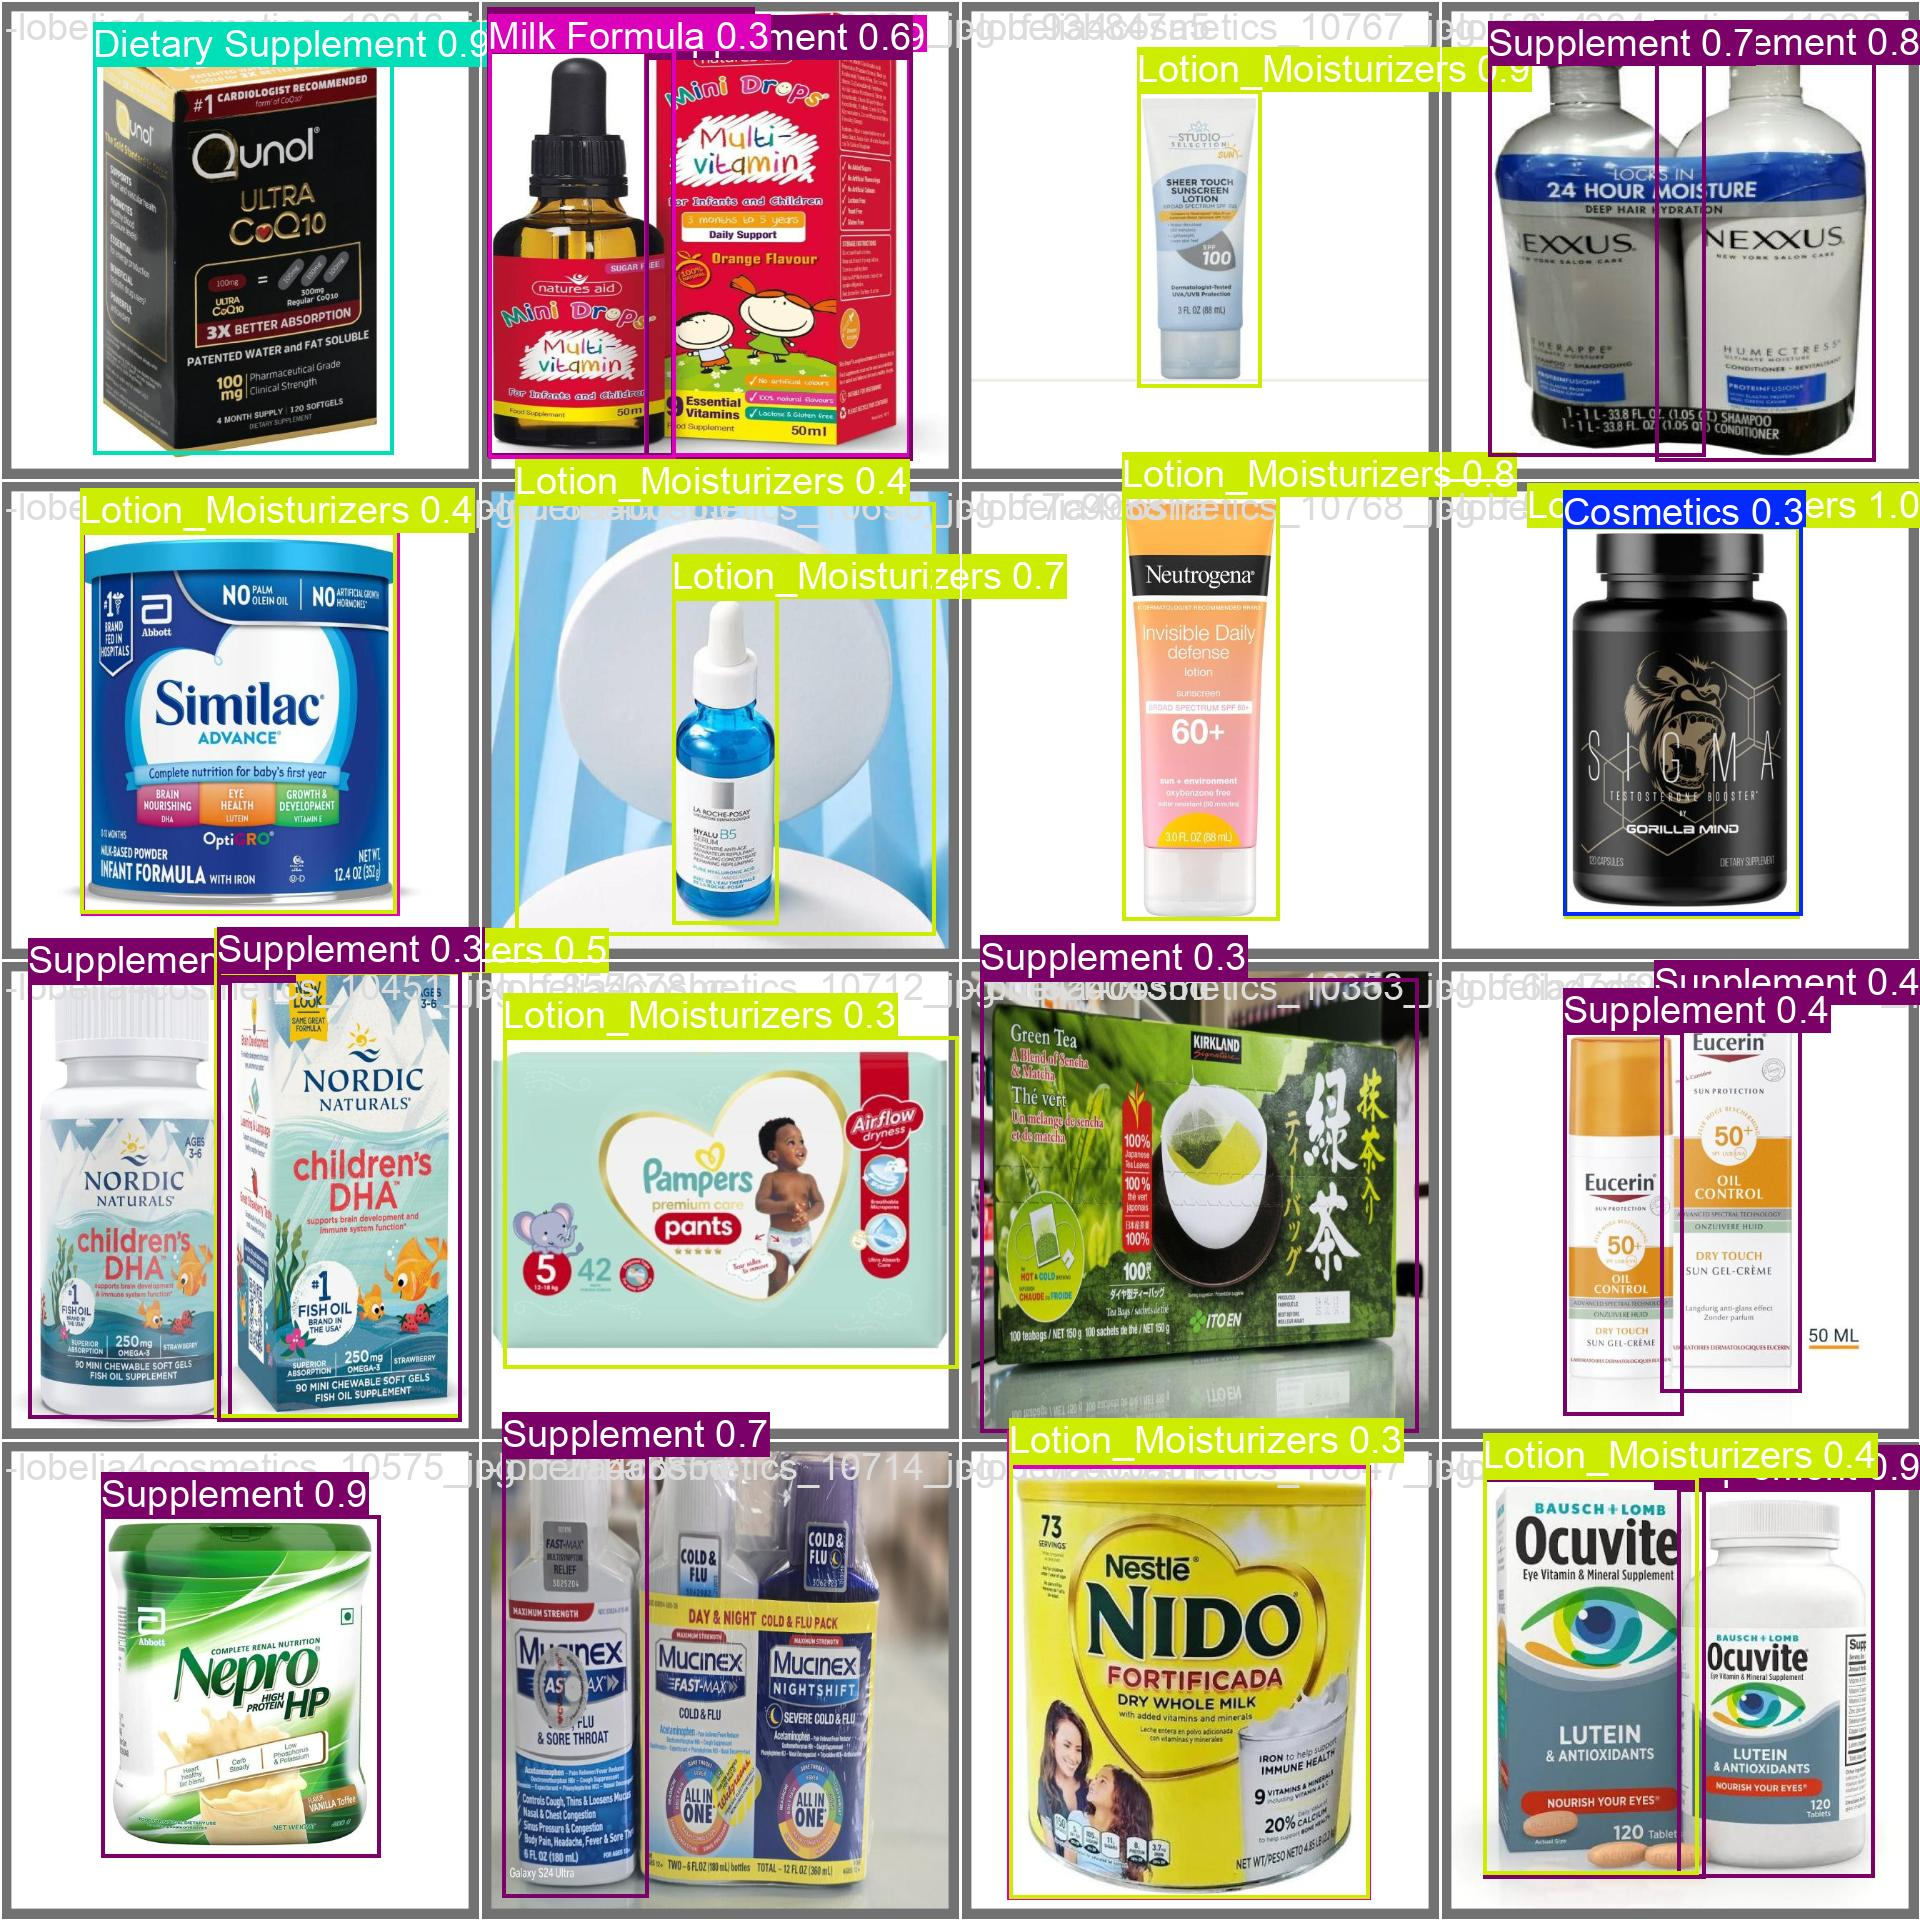

In [ ]:
IPyImage(filename=f'{HOME}/runs/detect/train4/val_batch0_pred.jpg', width=1000)

## Validate fine-tuned model

In [ ]:
!ls {HOME}/runs/detect/train4/weights

best.pt  last.pt


In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train4/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.13 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLO11s summary (fused): 238 layers, 9,420,153 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/MedData-Warehouse-1/valid/labels.cache... 48 images, 0 backgrounds, 0 corrupt: 100% 48/48 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 70. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:47<00:00, 15.70s/it]
                   all         48         70      0.517      0.224      0.214      0.189
             Cosmetics          1          1          0          0    0.00957   0.000957
           Description          4          4          1          0     0.0639     0.0464
               Diapers          1          1   

## Inference with custom model

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train4/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

**NOTE:** Let's take a look at few results.

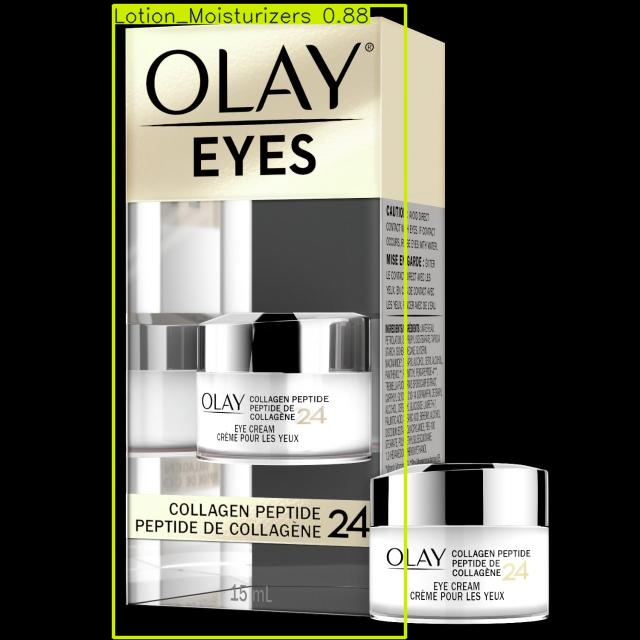

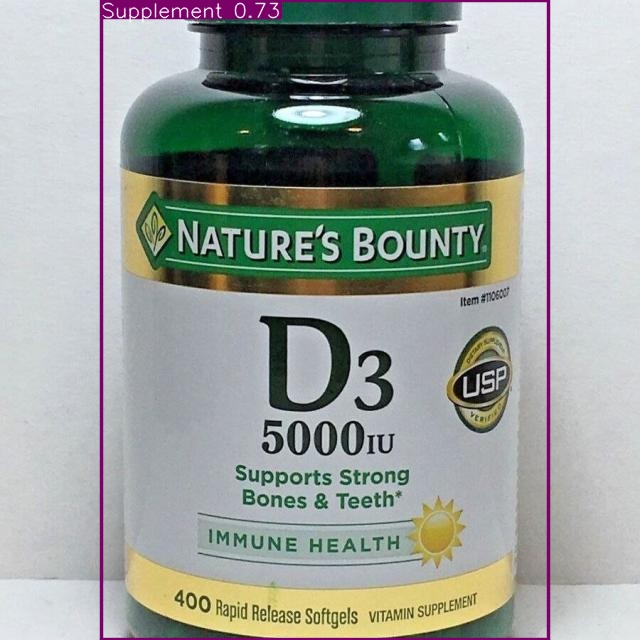

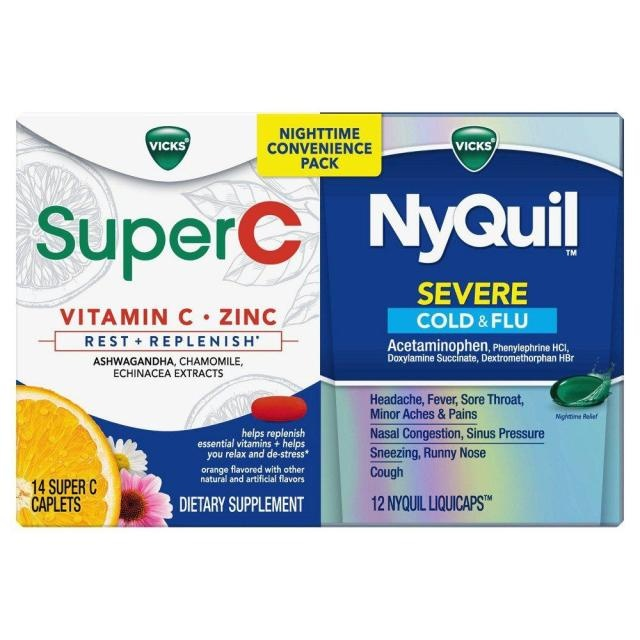

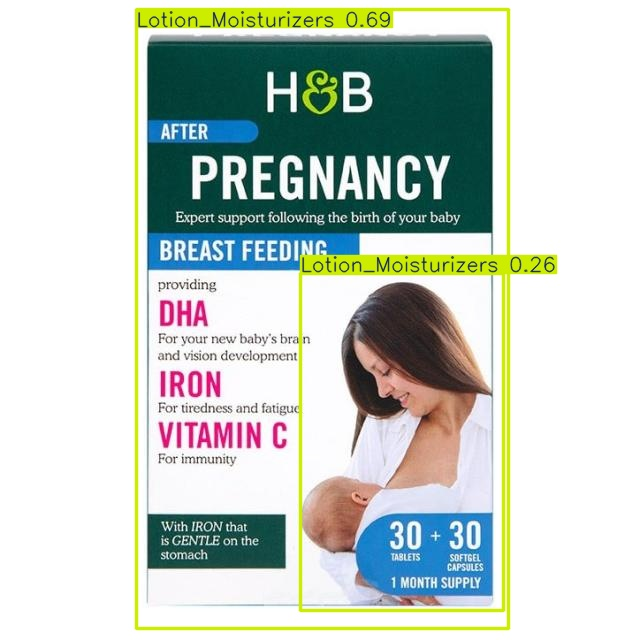

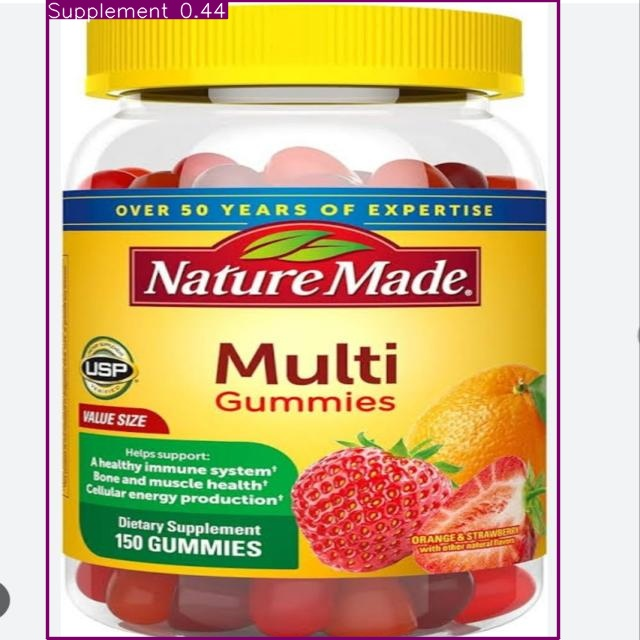

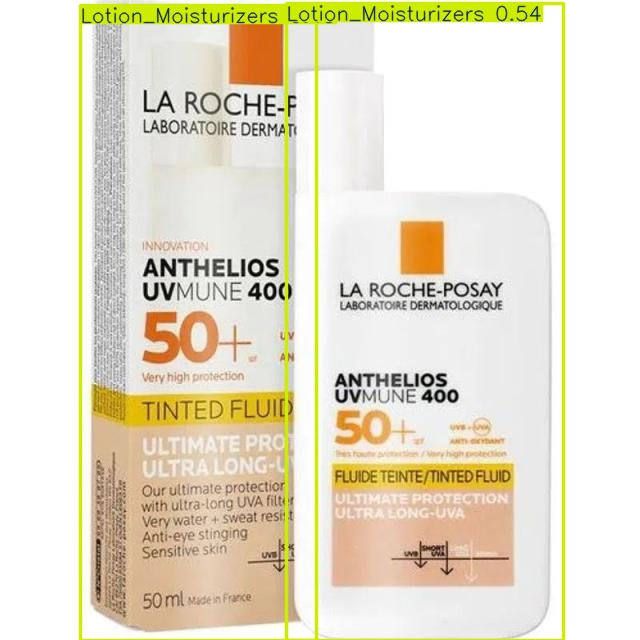

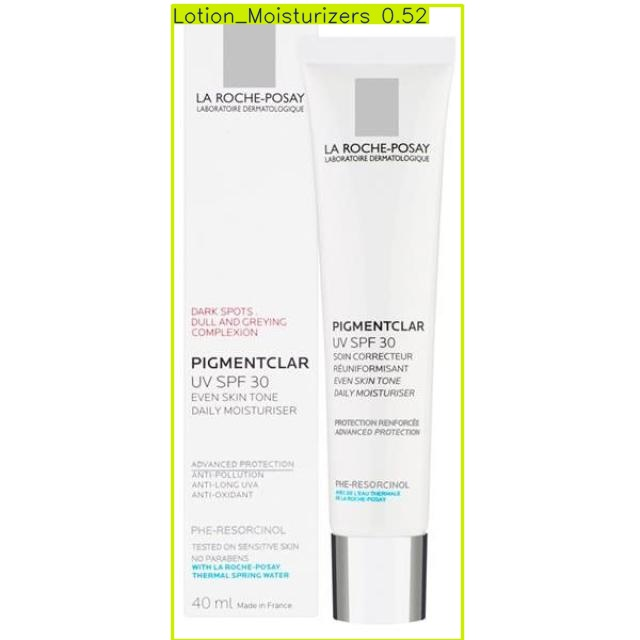

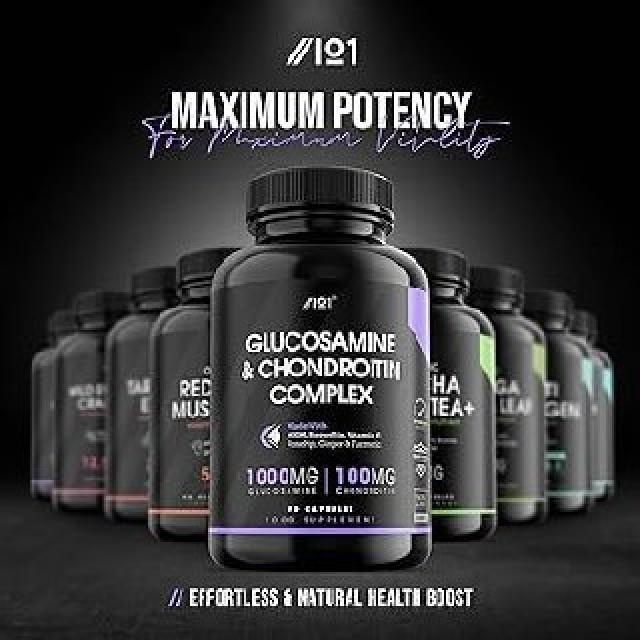

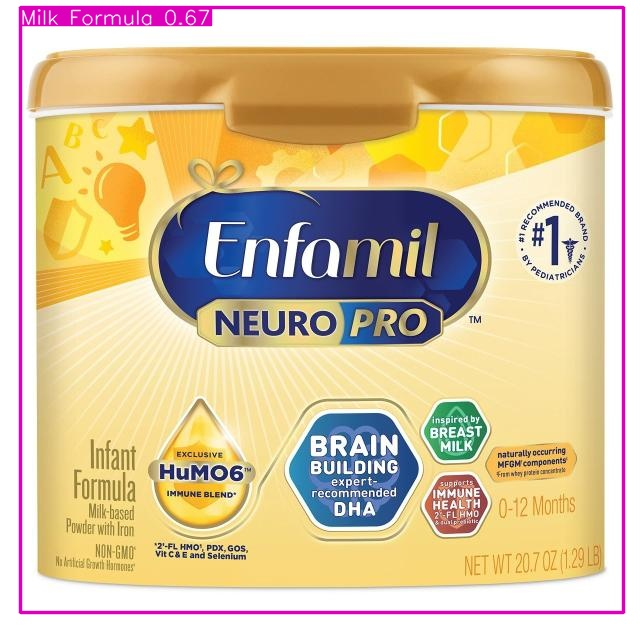

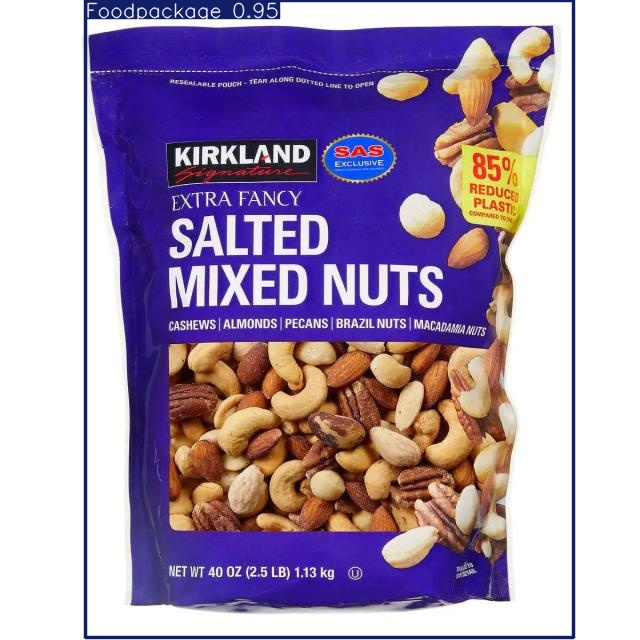

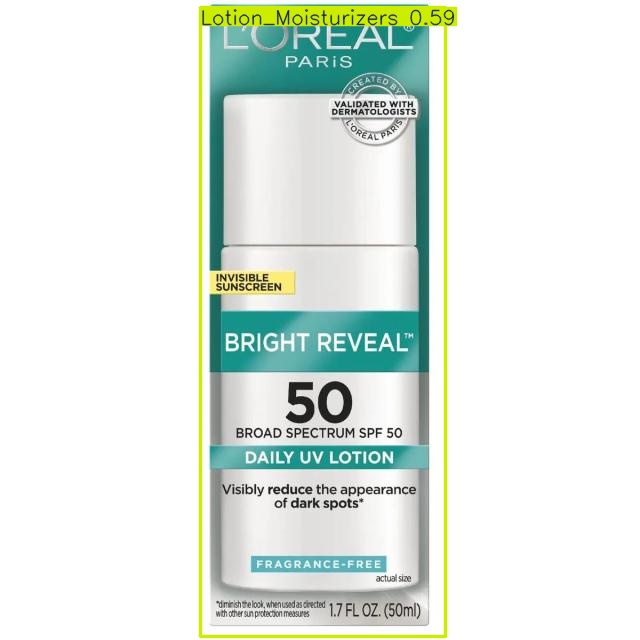

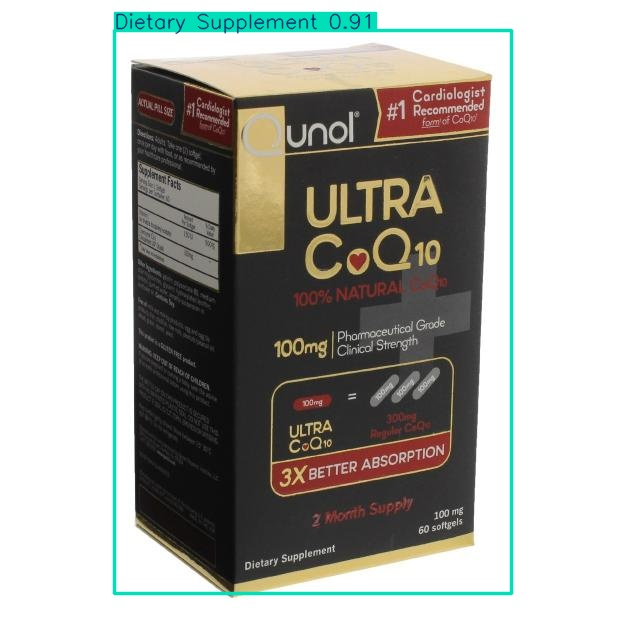

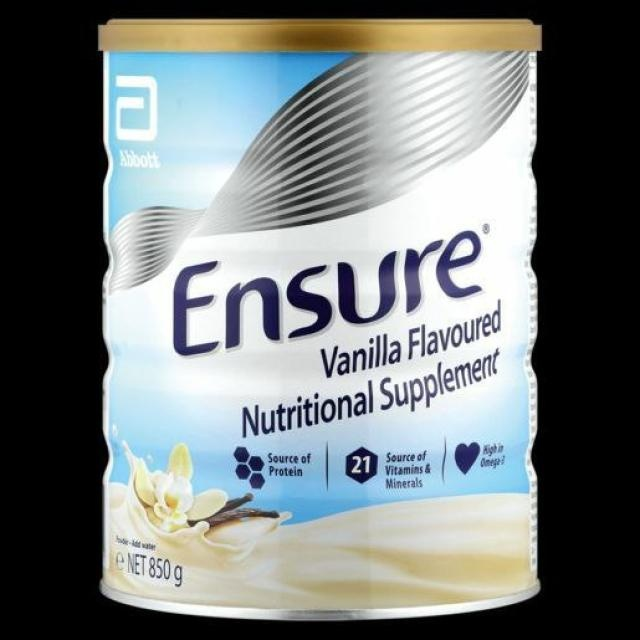

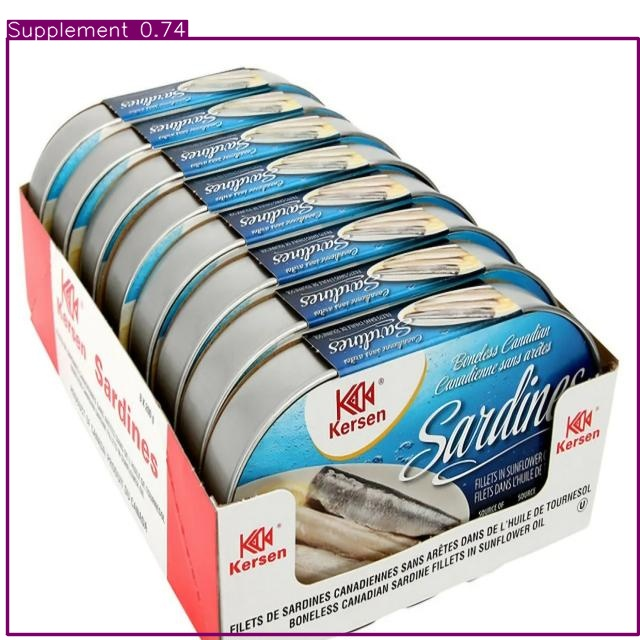

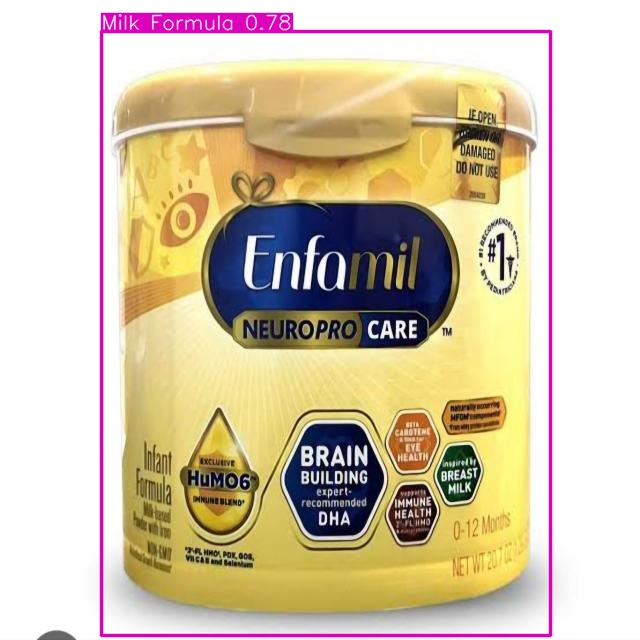

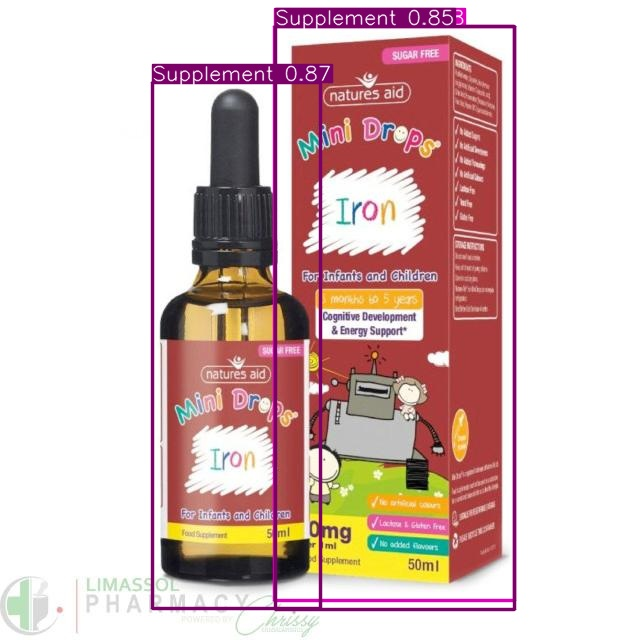

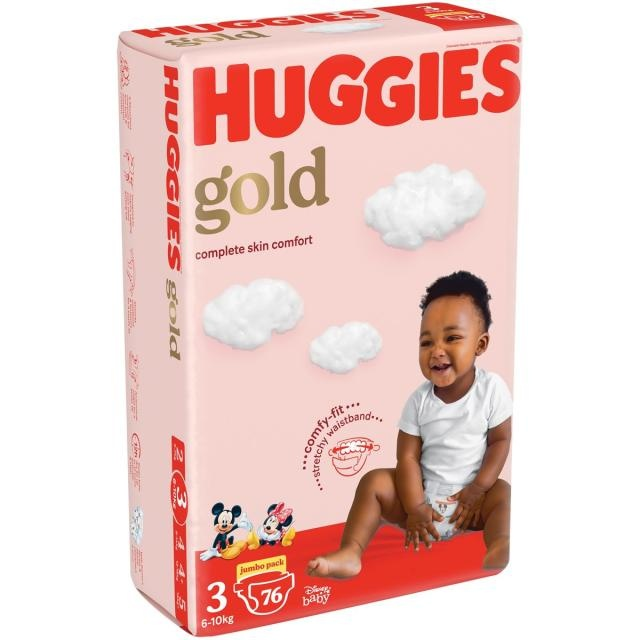

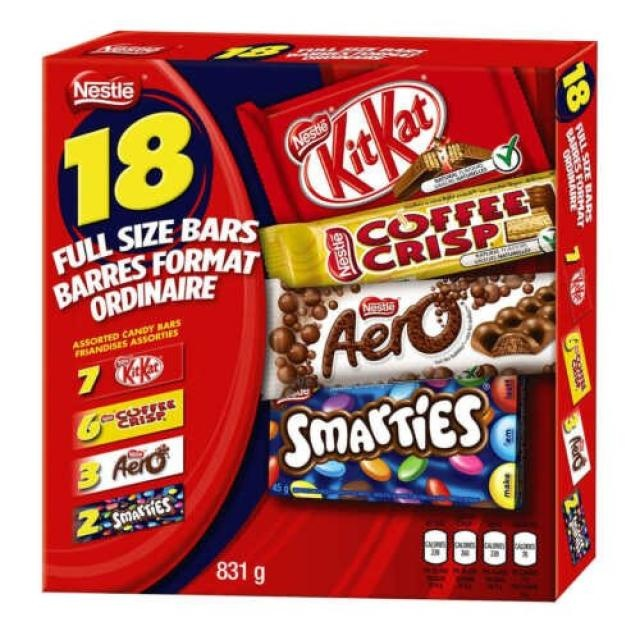

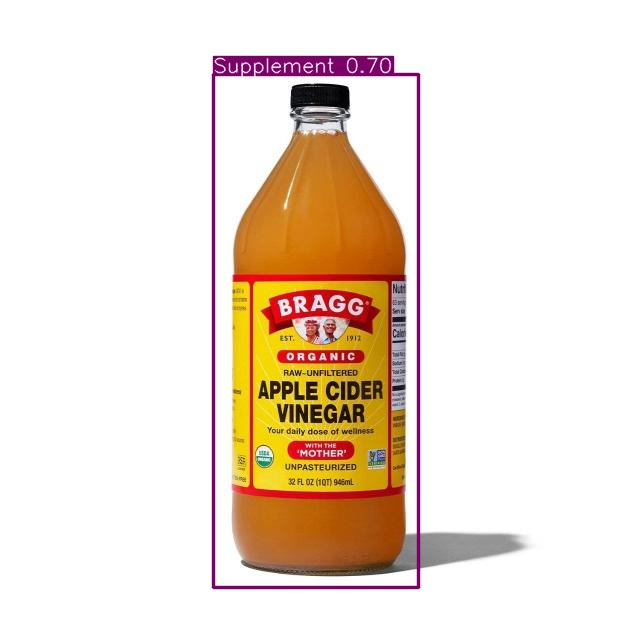

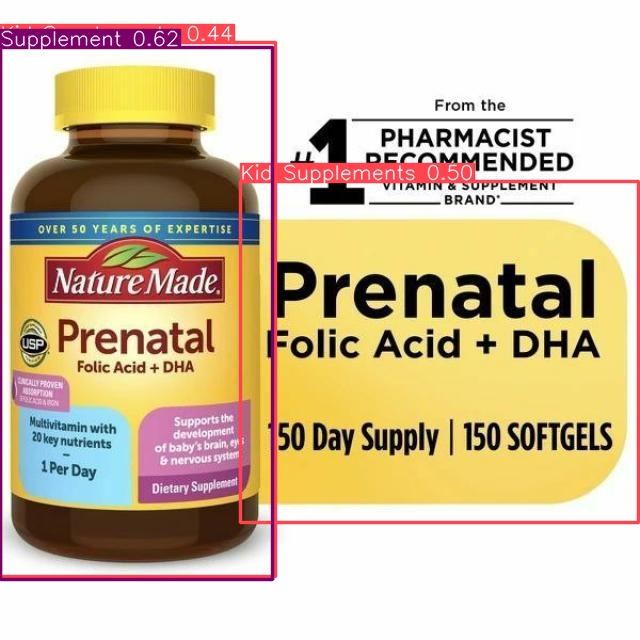

In [ ]:
from IPython.display import Image, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:20]:
    display(Image(filename=img, width=600))
    print("\n")

## Deploy model on Roboflow

Once I have finished training my YOLOv11 model, I’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train4/weights/best.pt` folder of my project. I can upload my model weights to Roboflow Deploy to use my trained weights on their infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [ ]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

In [ ]:
!pip install inference

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

Saving the Data

In [ ]:
# Saving model weight to google drive
import shutil

source_folder = '/content/runs'
destination_folder = '/content/drive/My Drive/Kifiya AIm/Week7/custom-model-yolo'

shutil.copytree(source_folder, destination_folder)

'/content/drive/My Drive/Kifiya AIm/Week7/custom-model-yolo'

In [ ]:
image_folder = '/content/drive/My Drive/Kifiya AIm/Week7/photos'
data_fraction = os.listdir(image_folder)[:5]

In [ ]:
model = YOLO(f'/content/runs/detect/train4/weights/best.pt')
for img_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_name)

    results = model(img_path)
    boxes = results[0].boxes

    if boxes is not None:
        bboxes = boxes.xyxy
        confidences = boxes.conf
        class_ids = boxes.cls

    class_labels = [results[0].names[int(cls)] for cls in class_ids]

    detections_list = []
    if boxes is not None:
        for i in range(len(bboxes)):
            detection = {
                'Image': img_name,
                'xmin': bboxes[i][0].item(),
                'ymin': bboxes[i][1].item(),
                'xmax': bboxes[i][2].item(),
                'ymax': bboxes[i][3].item(),
                'confidence': confidences[i].item(),
                'class': class_labels[i]
            }
            detections_list.append(detection)

        detections_df = pd.DataFrame(detections_list)

        csv_file = '/content/drive/My Drive/Kifiya AIm/Week7/detected_images.csv'

        if not os.path.isfile(csv_file):
            detections_df.to_csv(csv_file, index=False)
        else:
            detections_df.to_csv(csv_file, mode='a', header=False, index=False)

In [ ]:
# Downloading the result
from google.colab import files

files.download('/content/drive/My Drive/Kifiya AIm/Week7/detected_images.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>